In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import gzip
import datetime
import numpy as np
import pandas as pd
import sunpy.map
from sunpy.net import Fido, attrs as a

from sunkit_magex import pfss

import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

import astropy.units as u
import astropy.io.fits as fits
import astropy.constants as const
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, SqrtStretch, PercentileInterval
from aiapy.calibrate import normalize_exposure, register, update_pointing

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

year = '2021'
month = '09'
day = '18'

In [2]:
start_time = pd.Timestamp(f'{year}-{month}-{day} 00:00:00')
end_time = start_time + datetime.timedelta(minutes=1)

# Active region corona
result211 = Fido.search(a.Time(start_time, end_time),
                            a.Instrument('AIA'),
                            a.Wavelength(211*u.angstrom),
                            a.Sample(1*u.min))
aia211 = Fido.fetch(result211, path='./{instrument}/{file}')

# Corona and hot flare plasma
result193 = Fido.search(a.Time(start_time, end_time),
                            a.Instrument('AIA'),
                            a.Wavelength(193*u.angstrom),
                            a.Sample(1*u.min))
aia193 = Fido.fetch(result193, path='./{instrument}/{file}')

# Quiet corona, upper transition region
result171 = Fido.search(a.Time(start_time, end_time),
                            a.Instrument('AIA'),
                            a.Wavelength(171*u.angstrom),
                            a.Sample(1*u.min))
aia171 = Fido.fetch(result171, path='./{instrument}/{file}')

# Flaring regions
result94 = Fido.search(a.Time(start_time, end_time),
                            a.Instrument('AIA'),
                            a.Wavelength(94*u.angstrom),
                            a.Sample(1*u.min))
aia94 = Fido.fetch(result94, path='./{instrument}/{file}')

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [3]:
# adjust the path names to the data files
aia211_filename = glob.glob('./AIA/*_211a_*.fits')[0]
aia193_filename = glob.glob('./AIA/*_193a_*.fits')[0]
aia171_filename = glob.glob('./AIA/*_171a_*.fits')[0]
aia94_filename = glob.glob('./AIA/*_94a_*.fits')[0]

# aia211_filename = aia211[0].replace('\\', '/')
# aia193 = aia193[0].replace('\\', '/')
# aia171 = aia171[0].replace('\\', '/')
# aia94 = aia94[0].replace('\\', '/')

In [4]:
# calibrate AIA map to level 1.5
m211 = sunpy.map.Map(aia211_filename)
m211_updated_pointing = update_pointing(m211)
m211_registered = register(m211_updated_pointing)
m211_normalized = normalize_exposure(m211_registered)

m193 = sunpy.map.Map(aia193_filename)
m193_updated_pointing = update_pointing(m193)
m193_registered = register(m193_updated_pointing)
m193_normalized = normalize_exposure(m193_registered)

m171 = sunpy.map.Map(aia171_filename)
m171_updated_pointing = update_pointing(m171)
m171_registered = register(m171_updated_pointing)
m171_normalized = normalize_exposure(m171_registered)

m94 = sunpy.map.Map(aia94_filename)
m94_updated_pointing = update_pointing(m94)
m94_registered = register(m94_updated_pointing)
m94_normalized = normalize_exposure(m94_registered)

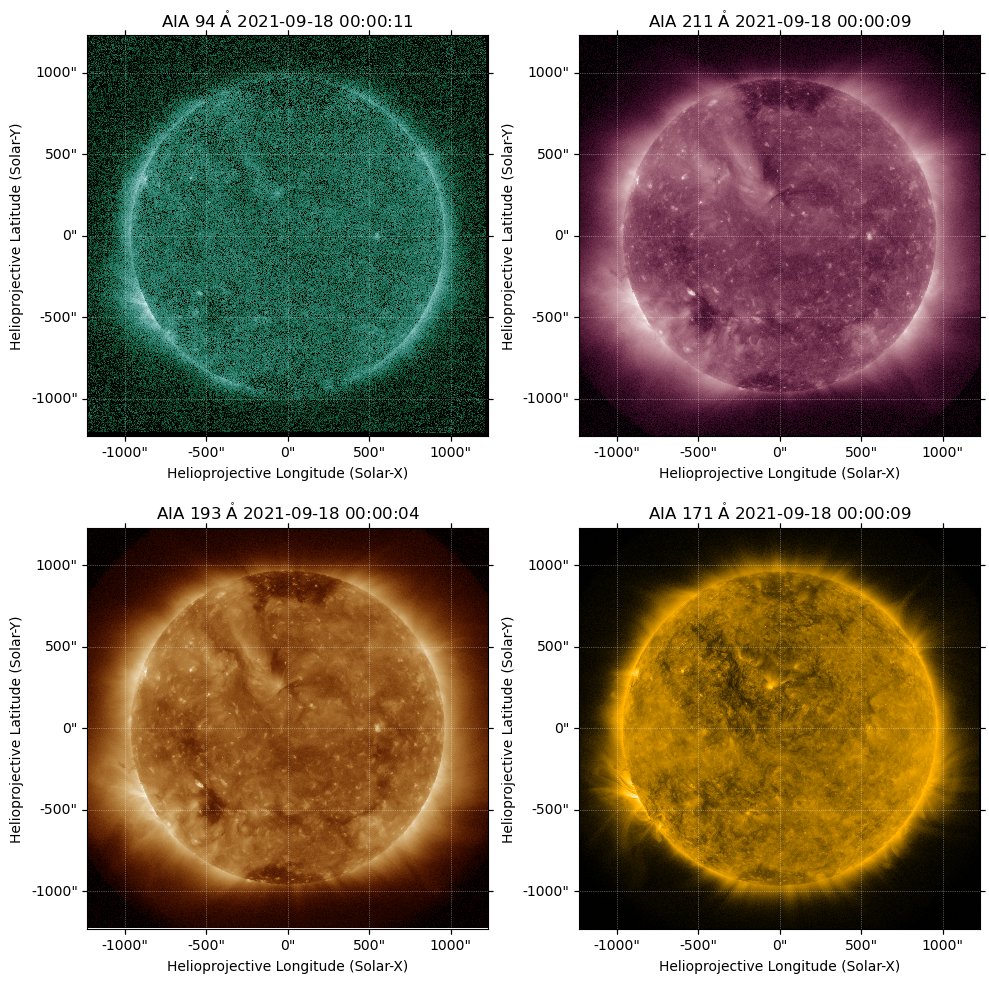

In [5]:
fig = plt.figure(figsize=[10,10])

ax = fig.add_subplot(221, projection=m94_normalized)
m94_normalized.plot(axes=ax, vmin=0)

ax = fig.add_subplot(222, projection=m211_normalized)
m211_normalized.plot(axes=ax, vmin=0)

ax = fig.add_subplot(223, projection=m193_normalized)
m193_normalized.plot(axes=ax, vmin=0)

ax = fig.add_subplot(224, projection=m171_normalized)
m171_normalized.plot(axes=ax, vmin=0)

fig.tight_layout()
plt.show()

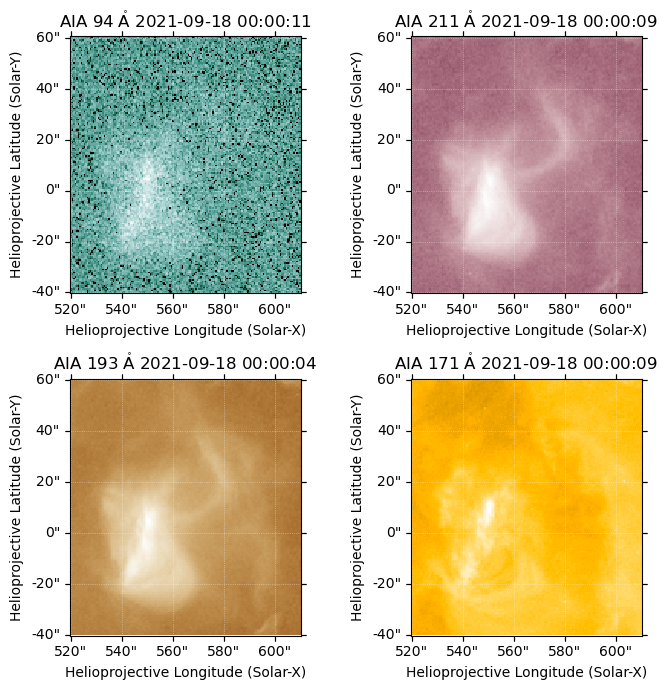

In [6]:
# we use the AIA image and focus the cutout over a bright spot
bottom_left_corner = SkyCoord(Tx=520*u.arcsec, Ty=-40*u.arcsec, frame=m193_normalized.coordinate_frame)
top_right_corner = SkyCoord(Tx=610*u.arcsec, Ty=60*u.arcsec, frame=m193_normalized.coordinate_frame)

aia94_sub = m94_normalized.submap(bottom_left_corner, top_right=top_right_corner)
aia211_sub = m211_normalized.submap(bottom_left_corner, top_right=top_right_corner)
aia193_sub = m193_normalized.submap(bottom_left_corner, top_right=top_right_corner)
aia171_sub = m171_normalized.submap(bottom_left_corner, top_right=top_right_corner)


fig = plt.figure(figsize=[7,7])

ax = fig.add_subplot(221, projection=aia94_sub)
aia94_sub.plot(axes=ax, vmin=0)

ax = fig.add_subplot(222, projection=aia211_sub)
aia211_sub.plot(axes=ax, vmin=0)

ax = fig.add_subplot(223, projection=aia193_sub)
aia193_sub.plot(axes=ax, vmin=0)

ax = fig.add_subplot(224, projection=aia171_sub)
aia171_sub.plot(axes=ax, vmin=0)

fig.tight_layout()
plt.show()

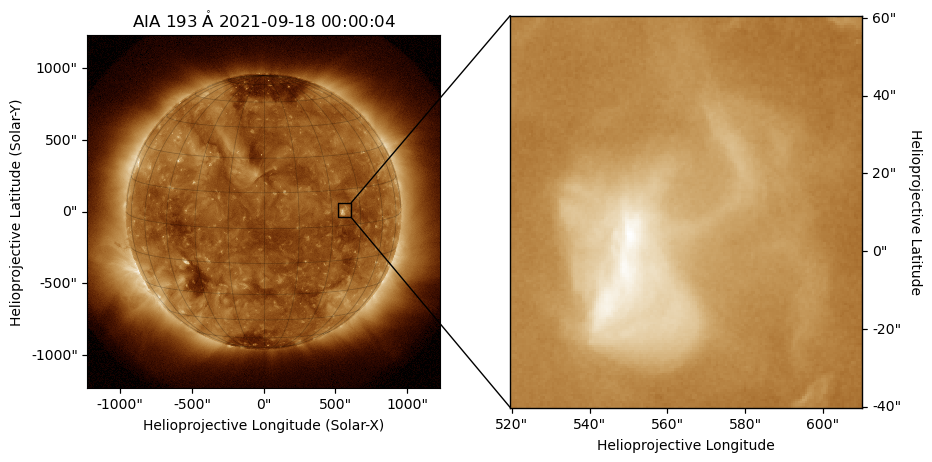

In [7]:
#### The first stage is plotting the full-disk AIA 193 Ao
fig = plt.figure(figsize=[10,7])

ax1 = fig.add_subplot(121, projection=m193_normalized)
m193_normalized.plot(axes=ax1, vmin=0, annotate=True)
m193_normalized.draw_grid(axes=ax1, color='black', alpha=0.25, lw=0.5)
ax1.grid(b=False)

# draw the rectangle around the region we plan to showcase in the cutout image 
m193_normalized.draw_quadrangle(bottom_left_corner, top_right=top_right_corner, edgecolor='black', lw=1)

#### The second stage is plotting the zoomed-in map 
aia193_small = m193_normalized.submap(bottom_left_corner, top_right=top_right_corner)
ax2 = fig.add_subplot(122, projection=aia193_small)

im = aia193_small.plot(axes=ax2, vmin=0, annotate=False)
ax2.grid(alpha=0)

# clean up the axis labels and ticks 
lon, lat = ax2.coords[0], ax2.coords[1]
lon.frame.set_linewidth(1)
lat.frame.set_linewidth(1)
lon.set_axislabel('Helioprojective Longitude',)
lon.set_ticks_position('b')
lat.set_axislabel('Helioprojective Latitude',)
lat.set_axislabel_position('r')
lat.set_ticks_position('r')
lat.set_ticklabel_position('r')

# we add two lines that will connect the two images as well as a colorbar 
xpix, ypix = m193_normalized.world_to_pixel(top_right_corner)
con1 = ConnectionPatch(
    (0,1), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax2, axesB=ax1, 
    arrowstyle='-', color='black', lw=1)

xpix, ypix = m193_normalized.world_to_pixel(SkyCoord(top_right_corner.Tx, bottom_left_corner.Ty, frame=m193_normalized.coordinate_frame))
con2 = ConnectionPatch(
    (0,0), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax2, axesB=ax1, 
    arrowstyle='-', color='black', lw=1)

ax2.add_artist(con1)
ax2.add_artist(con2)
# fig.savefig(f'{basedir_lof}/plots/aia_cutout.png', dpi=300, format='png', bbox_inches='tight')
# fig.savefig(f'{basedir_lof}/plots/aia_cutout.pdf', format='pdf', bbox_inches='tight')
plt.show()

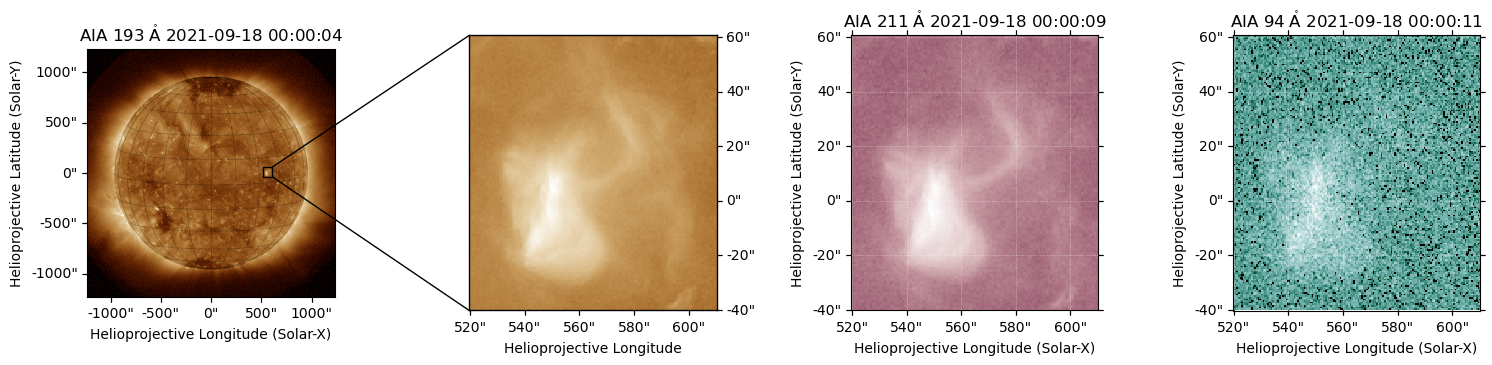

In [9]:
#### The first stage is plotting the full disk
fig = plt.figure(figsize=[15,7])

ax1 = fig.add_subplot(141, projection=m193_normalized)
m193_normalized.plot(axes=ax1, vmin=0, annotate=True)
m193_normalized.draw_grid(axes=ax1, color='black', alpha=0.25, lw=0.5)
ax1.grid(b=False)

# draw the rectangle around the region we plan to showcase in the cutout image 
m193_normalized.draw_quadrangle(bottom_left_corner, top_right=top_right_corner, edgecolor='black', lw=1)

#### The second stage is plotting the zoomed-in map 
aia193_small = m193_normalized.submap(bottom_left_corner, top_right=top_right_corner)
ax2 = fig.add_subplot(142, projection=aia193_small)

im = aia193_small.plot(axes=ax2, vmin=0, annotate=False)
ax2.grid(alpha=0)

# clean up the axis labels and ticks 
lon, lat = ax2.coords[0], ax2.coords[1]
lon.frame.set_linewidth(1)
lat.frame.set_linewidth(1)
lon.set_axislabel('Helioprojective Longitude')
lon.set_ticks_position('b')
# lat.set_axislabel('Helioprojective Latitude')
lat.set_axislabel(' ')
lat.set_axislabel_position('r')
lat.set_ticks_position('r')
lat.set_ticklabel_position('r')

# we add two lines that will connect the two images as well as a colorbar 
xpix, ypix = m193_normalized.world_to_pixel(top_right_corner)
con1 = ConnectionPatch(
    (0,1), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax2, axesB=ax1, 
    arrowstyle='-', color='black', lw=1)

xpix, ypix = m193_normalized.world_to_pixel(SkyCoord(top_right_corner.Tx, bottom_left_corner.Ty, frame=m193_normalized.coordinate_frame))
con2 = ConnectionPatch(
    (0,0), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax2, axesB=ax1, 
    arrowstyle='-', color='black', lw=1)

ax2.add_artist(con1)
ax2.add_artist(con2)

ax3 = fig.add_subplot(143, projection=aia211_sub)
aia211_sub.plot(axes=ax3, vmin=0)

ax4 = fig.add_subplot(144, projection=aia94_sub)
aia94_sub.plot(axes=ax4, vmin=0)

fig.tight_layout()
# fig.savefig('./aia_cutout.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

Apply the PFSS coronal magnetic field model

In [75]:
# # Fetch the list of files available on the server
# url = f'https://gong2.nso.edu/oQR/zqs/{year}{month}/mrzqs{year[-2:]}{month}{day}/'
# response = urllib.request.urlopen(url)
# html = response.read().decode("utf-8")

# # Filter the list to find the file that matches your criteria
# files = [f.split('"')[1] for f in html.split() if ".fits.gz" in f]
# gong_filename = [f for f in files if f.startswith(f"mrzqs{year[-2:]}{month}{day}t")][0]

# if not os.path.exists(f'./GONG/{gong_filename}') and not os.path.exists(f'./GONG/{gong_filename}'):
#     import urllib.request
#     urllib.request.urlretrieve(
#         f'https://gong2.nso.edu/oQR/zqs/{year}{month}/mrzqs{year[-2:]}{month}{day}/{gong_filename}',
#         f'./GONG/{gong_filename}')

# # Check if the uncompressed .fit file already exists
# if not os.path.exists(f'./GONG/{gong_filename[:-3]}'):
#     # Open the compressed file and read its content
#     with gzip.open(f'./GONG/{gong_filename}', 'rb') as f_in:
#         # Extract the content and write it to a new .fit file
#         with open(f'./GONG/{gong_filename[:-3]}', 'wb') as f_out:
#             f_out.write(f_in.read())

In [80]:
# if not os.path.exists(f'./GONG/{gong_filename[:-3]}'):
#     with gzip.open(f'./GONG/{gong_filename}', 'rb') as f:
#         with open(f'./GONG/{gong_filename[:-3]}', 'wb') as g:
#             g.write(f.read())

In [2]:
gong_result = Fido.search(a.Time(f'{year}-{month}-{day} 00:00:00', f'{year}-{month}-{day} 01:00:00'), a.Instrument('GONG'))
gong = Fido.fetch(gong_result, path='./{instrument}/{file}')
gong_map = sunpy.map.Map(gong)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


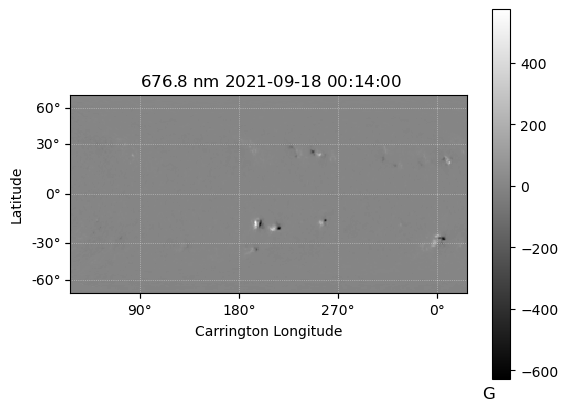

In [3]:
gong_map.peek()

In [4]:
# The PFSS solution is calculated on a regular 3D grid in (phi, s, rho), where
# rho = ln(r), and r is the standard spherical radial coordinate. We need to
# define the number of rho grid points, and the source surface radius.
nrho = 35
rss = 2.5

# From the boundary condition, number of radial grid points, and source
# surface, we now construct an Input object that stores this information
pfss_in = pfss.Input(gong_map, nrho, rss)
pfss_out = pfss.pfss(pfss_in)

In [73]:
# Now take a seed point, and trace a magnetic field line through the PFSS solution from these grid points
tracer = pfss.tracing.FortranTracer()

# We construct a lat x lon grid of footpoitns to trace some magnetic field lines from. 
# These coordinates are defined in the helioprojective frame of the AIA image. 
r = 1.2*const.R_sun
num_footpoints_lat = 42 #40
num_footpoints_lon = 60 #60
lat = np.linspace(np.radians(-75), np.radians(75), num_footpoints_lat, endpoint=False)
lon = np.linspace(np.radians(0), np.radians(365), num_footpoints_lon, endpoint=False)

lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel()*u.rad, lon.ravel()*u.rad

seeds = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)
field_lines = tracer.trace(seeds, pfss_out)

In [ ]:
# Map of the footpoints
fig = plt.figure(figsize=[10,10])
ax = plt.subplot(projection=m211_normalized)
m211_normalized.plot(axes=ax, vmin=0, cmap='gray_r')
ax.plot_coord(seeds, color='red', marker='o', linewidth=0, markersize=2)
fig.tight_layout()
fig.savefig(f"./aia_pfss_seeds_{m211_normalized.meta['date'].split('T')[0]}.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Plot the magnetogram and the seed footpoints
m = pfss_in.map

fig = plt.figure(figsize=[10,5])
ax = plt.subplot(projection=m)
gon = m.plot()
ax.plot_coord(seeds, color='black', marker='o', linewidth=0, markersize=2)
fig.colorbar(gon, shrink=0.8, pad=0.03, label=m.meta['bunit'])
ax.set_title(f"{gong_map.meta['obs-site']} {str(m.date).replace('T', ' ')}")
fig.tight_layout()
fig.savefig(f"./gong_pfss_seeds_{str(m.date).split(' ')[0]}.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=[10,10])
ax = plt.subplot(111, projection=m211_normalized)

# draw the AIA map
im = m211_normalized.plot(axes=ax, norm=ImageNormalize(interval=PercentileInterval(90)), cmap='gray_r')
m211_normalized.draw_limb(axes=ax, color='orange')

# draw the PFSS field lines
for fline in field_lines:
    color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(fline.polarity)
    ax.plot_coord(fline.coords, alpha=0.3, color=color, linewidth=1)

ax.grid(b=False)
ax.set_xlim(0, m211_normalized.meta['naxis1'])
ax.set_ylim(0, m211_normalized.meta['naxis2'])
fig.tight_layout()
fig.savefig(f"./aia_pfss_colored_{m211_normalized.meta['date'].split('T')[0]}.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=[10,10])
ax = plt.subplot(111, projection=m211_normalized)
m211_normalized.plot(axes=ax, vmin=0)

# draw the PFSS field lines
for fline in field_lines:
    ax.plot_coord(fline.coords, alpha=0.3, color='white', linewidth=1)

ax.grid(b=False)
ax.set_xlim(0, m211_normalized.meta['naxis1'])
ax.set_ylim(0, m211_normalized.meta['naxis2'])
fig.tight_layout()
fig.savefig(f"./aia_pfss_{m211_normalized.meta['date'].split('T')[0]}.png", format='png', dpi=300, bbox_inches='tight')
plt.show()